In [1]:
# To create python file:
# jupyter nbconvert --to=python lang_model_new.ipynb

import utils.data_import as data_import
import utils.imdb_data as imdb_data
import utils.ml_utils as ml_utils
import model.neural as neural

import torch
import torch.nn as nn
import torch.optim as optim

from torchtext import data, vocab

import os, sys
import pdb
import pandas as pd
import numpy as np
import math
#from tqdm import tnrange, tqdm_notebook
from tqdm import tqdm

import importlib

import settings

np.random.seed(123)

/anaconda3/envs/ONE/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


In [2]:
in_notebook = ml_utils.in_ipynb()
print('Running in notebook:', in_notebook)

Running in notebook: True


In [3]:
cuda = torch.cuda.is_available()
if cuda:
    print('Cuda is available!')
    print('Device:', torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print('No cuda.')

if in_notebook:
    import matplotlib.pyplot as plt
    %matplotlib inline

No cuda.


In [4]:
corpus = imdb_data.ImdbCorpus(filename=settings.imdb_file, lines=settings.lines_imbd, vocab_file='vocab.p')
corpus.train.itoklist_df.head()

Importing vocab from vocab.p... Done.
Imported vocab:  10,954
Read total of: 1,000 lines from imdb file.
Number of classes: 2: {'negative': 0, 'positive': 1}
Generated train: 700 lines
Generated valid: 150 lines
Generated test:  150 lines


/anaconda3/envs/ONE/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda3/envs/ONE/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,sentiment,review,len
498,0,"[1249, 9389, 38, 1384, 38, 2, 5207, 119, 18, 2...",206
243,0,"[456, 1871, 23, 2158, 7264, 3995, 10618, 185, ...",185
314,0,"[247, 130, 158, 216, 154, 598, 44, 456, 57, 16...",142
202,0,"[140, 241, 2819, 18, 3922, 18, 60, 5290, 2, 44...",114
300,0,"[2, 2, 300, 10611, 5830, 24, 2, 105, 21, 387, ...",889


In [5]:
train_dl = imdb_data.ImdbTextDataset(corpus.train, pad_idx=corpus.vocab.stoi['<pad>'],
                                     batch_size=settings.batch_size_imdb, seq_length=settings.window_size_imbd, 
                                     rand_range=5, sort=True, rebatch_and_shuffle=True)
valid_dl = imdb_data.ImdbTextDataset(corpus.valid, pad_idx=corpus.vocab.stoi['<pad>'],
                                     batch_size=settings.batch_size_imdb, seq_length=settings.window_size_imbd, 
                                     rand_range=5, sort=True)
test_dl = imdb_data.ImdbTextDataset(corpus.test, pad_idx=corpus.vocab.stoi['<pad>'],
                                    batch_size=settings.batch_size_imdb, seq_length=settings.window_size_imbd, 
                                    rand_range=5, sort=True)

 Number of batches: 23
 Preserved texts: 690
 Matrix size:       torch.Size([3627, 30])
 Number of batches: 5
 Preserved texts: 150
 Matrix size:       torch.Size([846, 30])
 Number of batches: 5
 Preserved texts: 150
 Matrix size:       torch.Size([834, 30])


In [6]:
if in_notebook:
    train_x, train_y = next(iter(train_dl))
    print(train_x)
    print(train_y)
    print(train_dl.itoklistFrame.batch_start_end)

tensor([[ 6399,  1249,  1249,  ...,   247,   158,  1249],
        [  962,   552,   589,  ...,   130,  4296,   552],
        [   47, 10055,    23,  ...,   158,    18,   503],
        ...,
        [    0,     0,     0,  ...,  8416,     2,    97],
        [    0,     0,     0,  ...,    16,     2,    16],
        [    0,     0,     0,  ...,     1,     1,     1]])
tensor([0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
        1, 1, 0, 0, 0, 1])
[[649, 792], [941, 1096], [513, 649], [3083, 3268], [0, 61], [2535, 2721], [3446, 3627], [149, 264], [2907, 3083], [1435, 1612], [792, 941], [264, 385], [2163, 2349], [385, 513], [2721, 2907], [3268, 3446], [1263, 1435], [2349, 2535], [1612, 1795], [1795, 1979], [1979, 2163], [61, 149], [1096, 1263]]


In [7]:
if in_notebook:
    for idx, (x, y) in enumerate(train_dl):
        if idx >= 2:
            break
        print(idx, len(x[:,1]))
        for i in x[:,1]:
            print(corpus.vocab.itos[i], end=' ')
        print('##', corpus.classes.itos[y[1].item()], '##')

0 142
i just watched <unk> <unk> return to <unk> <unk> streets of <unk> and dead <unk> walk . all excellent . this sorry <unk> of <unk> is <unk> done and poorly acted <unk> in the previous <unk> captain call and <unk> <unk> come off as <unk> <unk> <unk> . despite the fact that <unk> call is played by a different actor every time each one quickly won me over . in dead <unk> walk the boys are <unk> as the younger versions of the experienced texas <unk> . in <unk> moon they are just a couple of <unk> <unk> . i had to stop watching <unk> i <unk> many of the <unk> reviews for this show were written by the people who made this <unk> pile . <unk> a sorry end to an otherwise great franchise . <eol> <pad> <pad> <pad> <pad> <pad> ## negative ##
1 154
i have to <unk> seventeen & missing is much better than i expected . the perception i took from the <unk> was that it would be just <unk> but i was <unk> surprised with this impressive mystery <unk> <unk> <unk> is <unk> a <unk> who <unk> her <unk> <

In [8]:
model = neural.class_model_LSTM(vocab_dim=len(corpus.vocab),
                                emb_dim=settings.emb_dim,
                                hidden_dim=settings.hidden_dim,
                                n_layers=settings.num_layers,
                                dropout=settings.dropout,
                                n_classes=corpus.n_classes
                               )

In [9]:
if cuda:
    model = model.cuda()

In [10]:
print(model)

class_model_LSTM(
  (embedding): Embedding(10954, 50)
  (lstm): LSTM(50, 300, num_layers=2, dropout=0.4, bidirectional=True)
  (fc): Linear(in_features=600, out_features=2, bias=True)
  (dropout): Dropout(p=0.4)
)


In [11]:
model = torch.load('model_weights_imdb_300.pt')

In [12]:
missclass = []
missclass_next = []
losses = []

In [13]:
def run_epochs(model, train_dl, valid_dl, epochs=settings.epochs,
               losses=[], missclass=[]):
    
    opt = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)
    #opt = optim.Adam(model.parameters(), lr=0.001)
    #loss_func = nn.NLLLoss()
    loss_func = nn.CrossEntropyLoss()
    
    scheduler = optim.lr_scheduler.StepLR(opt, step_size=20, gamma=0.8)
    
    best_missclass_te = 1e10
    
    try: # Allow for user interrupt
 
        for epoch in range(1, epochs + 1):
            
            scheduler.step()
            running_loss = 0.0
            running_corrects = 0
            model.train() # turn on training mode

            num_vals = 0
            num_correct = 0

            #pdb.set_trace()

            for x, y in tqdm(train_dl, desc='Train {}/{}'.format(epoch, epochs)):
                opt.zero_grad()
                
                if cuda:
                    x = x.cuda()
                    y = y.cuda()

                preds = model(x)
                loss = loss_func(preds, y.long())

                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 0.25)
                opt.step()

                running_loss += loss.item() * x.size(0) / x.size(1)

                _, y_preds = torch.max(preds, dim=1)
                num_correct += torch.sum(y == y_preds).item()
                num_vals += y.size(0)

            #pdb.set_trace()

            missclass_tr = 1 - num_correct / num_vals

            epoch_loss = running_loss / len(train_dl)

            num_vals = 0
            num_correct = 0

            # calculate the validation loss for this epoch
            val_loss = 0.0
            model.eval() # turn on evaluation mode
            
            with torch.no_grad():
                for x, y in tqdm(valid_dl, desc='Valid {}/{}'.format(epoch, epochs)):
                    if cuda:
                        x = x.cuda()
                        y = y.cuda()   
                        
                    preds = model(x)
                    loss = loss_func(preds, y.long())

                    val_loss += loss.item() * x.size(0) / x.size(1)

                    _, y_preds = torch.max(preds, dim=1)
                    num_correct += torch.sum(y == y_preds).item()
                    num_vals += y.size(0)

            #pdb.set_trace()

            missclass_te = 1 - num_correct / num_vals
            val_loss /= len(valid_dl)
            
            missclass.append((missclass_tr, missclass_te))
            losses.append((epoch_loss, val_loss))

            print('Epoch: {}/{}, Loss: [{:.4f}, {:.4f}], Miss: [{:.2%}, {:.2%}]'\
                  .format(epoch, epochs, epoch_loss, val_loss, 
                          missclass_tr, missclass_te))
            sys.stdout.flush()

            if missclass_te < best_missclass_te:
                print('Improved validation. Saving weights file...', end=' ', flush=True)
                torch.save(model, 'model_weights_imdb_300.pt')
                print('Done.', flush=True)
                best_missclass_te = missclass_te
            
    except KeyboardInterrupt:
        print('Stopping with latest weights.')
        
    return model, opt, losses, missclass

In [14]:
model, opt, losses, missclass = run_epochs(model, train_dl, valid_dl, epochs=settings.epochs,
                                           losses=losses, missclass=missclass)

Train 1/10:  13%|█▎        | 3/23 [00:09<01:03,  3.19s/it]

Stopping with latest weights.


In [15]:
x, y = next(iter(valid_dl))
if cuda:
    x = x.cuda()
    y = y.cuda()
loss_func = nn.CrossEntropyLoss()
preds = model(x)
_, y_preds = torch.max(preds, dim=1)
loss = loss_func(preds, y.long())
loss

tensor(2.0802, grad_fn=<NllLossBackward>)

In [16]:
print(y.shape)
print(y[:])

torch.Size([30])
tensor([1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
        0, 1, 1, 1, 1, 1])


In [17]:
print(y_preds[:])
print(preds)

tensor([1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
        0, 0, 1, 1, 1, 1])
tensor([[-1.3594,  1.9757],
        [-5.8589,  4.5518],
        [-3.6115,  3.6212],
        [ 2.4391, -3.5015],
        [-2.7058,  1.4551],
        [-3.7280,  3.4330],
        [ 5.3058, -4.5454],
        [-3.4714,  2.6797],
        [ 3.7521, -5.2298],
        [ 1.9088, -2.1255],
        [ 4.0376, -4.4046],
        [ 4.3677, -4.9762],
        [ 2.5214, -2.4705],
        [-3.6107,  2.5149],
        [-0.9628,  0.0898],
        [-3.4392,  2.7303],
        [-5.0814,  3.8719],
        [-3.3890,  2.0190],
        [-1.7097,  0.3362],
        [-2.1474,  1.6244],
        [ 4.2879, -4.3036],
        [-2.1844,  1.3727],
        [ 3.9586, -4.3256],
        [-5.4731,  3.9186],
        [ 2.3052, -1.7960],
        [ 2.5956, -2.7325],
        [-4.0342,  2.9954],
        [-2.3212,  2.2222],
        [-3.1035,  1.8777],
        [-4.7055,  3.6266]], grad_fn=<ThAddmmBackward>)


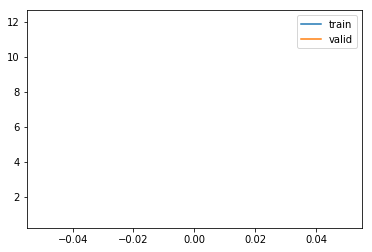

In [18]:
if in_notebook:
    plt.plot(losses)
    plt.legend(['train', 'valid'])

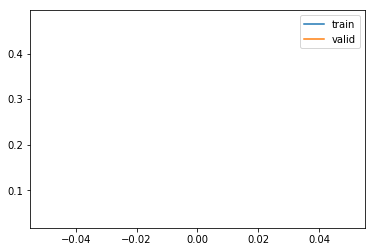

In [19]:
if in_notebook:
    plt.plot(missclass)
    plt.legend(['train', 'valid'])